In [2]:
# Import packages

from __future__ import print_function, division
from IPython.display import display, HTML

import pandas as pd
import numpy as np

from tqdm import tqdm

# import statsmodels.api as sm
from statsmodels import tsa
import statsmodels.api as sm
from datetime import date, datetime, timedelta
import copy
import scipy as sp
from scipy.optimize import fsolve
from scipy.stats import norm
from scipy.optimize import minimize
from scipy import interpolate
import datetime

from cycler import cycler
import matplotlib.pyplot as plt
import matplotlib.patches as patches
import matplotlib as mpl
import matplotlib.dates

# Plotting and display options
np.set_printoptions(precision=3)
pd.set_option('precision', 2)
pd.set_option('display.float_format', lambda x: '%.2f' % x)

plt.style.use('ggplot')

mpl.rcParams['lines.linewidth'] = 1.5
mpl.rcParams['lines.color'] = 'blue'
mpl.rcParams['axes.prop_cycle'] = cycler('color', ['#30a2da', '#e5ae38', '#fc4f30', '#6d904f', '#8b8b8b'])
mpl.rcParams['legend.fancybox'] = True
mpl.rcParams['legend.fontsize'] = 14
mpl.rcParams['axes.facecolor'] = '#f0f0f0'
mpl.rcParams['axes.labelsize'] = 15
mpl.rcParams['axes.axisbelow'] = True
mpl.rcParams['axes.linewidth'] = 1.2
mpl.rcParams['axes.labelpad'] = 0.0
mpl.rcParams['axes.xmargin'] = 0.05  # x margin.  See `axes.Axes.margins`
mpl.rcParams['axes.ymargin'] = 0.05  # y margin See `axes.Axes.margins`
mpl.rcParams['xtick.labelsize'] = 14
mpl.rcParams['ytick.labelsize'] = 14
mpl.rcParams['figure.subplot.left'] = 0.08
mpl.rcParams['figure.subplot.right'] = 0.95
mpl.rcParams['figure.subplot.bottom'] = 0.07

# figure configuration
fsize = (20, 10) # figure size
tsize = 18 # title font size
lsize = 16 # legend font size
csize = 14 # comment font size
grid = True # grid

# this allows plots to appear directly in the notebook
%matplotlib inline

# pandas settings
pd.set_option('precision', 6)
pd.set_option('display.float_format', lambda x: '%.6f' % x)

# this allows plots to appear directly in the notebook
get_ipython().magic(u'matplotlib inline')


In [10]:
apple = pd.read_csv('apple.csv', index_col=0, header=0)
apple['PERMNO'] = apple.index
apple['date'] = apple['date'].apply(lambda x: datetime.datetime.strptime(str(x), '%Y%m%d'))
apple = apple.reset_index(drop=True)
apple.head()

,date,SHRCD,EXCHCD,SICCD,COMNAM,NAICS,DCLRDT,PAYDT,RCRDDT,DISTCD,DIVAMT,PRC,VOL,CFACPR,PERMNO
0,1980-12-12,11,3,3573,APPLE COMPUTER INC,nan,nan,nan,nan,nan,nan,-28.812500,nan,56.000000,14593
1,1980-12-15,11,3,3573,APPLE COMPUTER INC,nan,nan,nan,nan,nan,nan,-27.312500,nan,56.000000,14593
2,1980-12-16,11,3,3573,APPLE COMPUTER INC,nan,nan,nan,nan,nan,nan,-25.312500,nan,56.000000,14593
3,1980-12-17,11,3,3573,APPLE COMPUTER INC,nan,nan,nan,nan,nan,nan,-25.937500,nan,56.000000,14593
4,1980-12-18,11,3,3573,APPLE COMPUTER INC,nan,nan,nan,nan,nan,nan,-26.687500,nan,56.000000,14593


In [11]:
# print('Before drop negative PRC, number of records:', apple.shape[0])
# apple = apple[apple['PRC'] >= 0]
# apple = apple.reset_index(drop=True)
# print('After drop negative PRC, number of records:', apple.shape[0])
apple['Adjust Price'] = abs(apple['PRC']) / apple['CFACPR']
apple['Adjust DIVAMT'] = apple['DIVAMT'] / apple['CFACPR']
apple.describe()

,SHRCD,EXCHCD,SICCD,NAICS,DCLRDT,PAYDT,RCRDDT,DISTCD,DIVAMT,PRC,VOL,CFACPR,PERMNO,Adjust Price,Adjust DIVAMT
count,9345.000000,9345.000000,9345.000000,3414.000000,60.000000,61.000000,61.000000,61.000000,61.000000,9344.000000,8846.000000,9344.000000,9345.000000,9344.000000,61.000000
mean,11.000000,3.000000,3572.408668,334111.063855,20003770.900000,20003844.065574,20003792.754098,1513.377049,0.573115,98.692630,12633389.680647,23.318921,14593.000000,21.917940,0.182693
std,0.000000,0.000000,0.912732,2.637826,117873.509043,116850.560449,116889.556435,1070.989950,0.946348,136.886591,16834388.831688,17.918398,0.000000,38.913631,0.245268
min,11.000000,3.000000,3571.000000,334111.000000,19870422.000000,19870615.000000,19870515.000000,1232.000000,0.000000,-36.062500,96125.000000,1.000000,14593.000000,0.197545,0.000000
25%,11.000000,3.000000,3571.000000,334111.000000,19901009.500000,19901214.000000,19901123.000000,1232.000000,0.110000,26.250000,1427814.500000,7.000000,14593.000000,1.035000,0.003929
50%,11.000000,3.000000,3573.000000,334111.000000,19940570.000000,19940909.000000,19940819.000000,1232.000000,0.120000,43.687500,4352976.000000,28.000000,14593.000000,1.629464,0.004286
75%,11.000000,3.000000,3573.000000,334111.000000,20140423.000000,20140515.000000,20140512.000000,1232.000000,0.520000,108.890000,19283411.000000,28.000000,14593.000000,20.560715,0.435714
max,11.000000,3.000000,3573.000000,334220.000000,20171102.000000,20171116.000000,20171113.000000,5523.000000,3.290000,702.099980,189848621.000000,56.000000,14593.000000,176.420000,0.630000


In [12]:
apple_div = apple[apple['DIVAMT'] > 0]
apple_div.head()

,date,SHRCD,EXCHCD,SICCD,COMNAM,NAICS,DCLRDT,PAYDT,RCRDDT,DISTCD,DIVAMT,PRC,VOL,CFACPR,PERMNO,Adjust Price,Adjust DIVAMT
1620,1987-05-11,11,3,3573,APPLE COMPUTER INC,nan,19870422.000000,19870615.000000,19870515.000000,1232.000000,0.120000,77.000000,881533.000000,56.000000,14593,1.375000,0.002143
1683,1987-08-10,11,3,3573,APPLE COMPUTER INC,nan,19870731.000000,19870915.000000,19870814.000000,1232.000000,0.060000,48.250000,751443.000000,28.000000,14593,1.723214,0.002143
1753,1987-11-17,11,3,3573,APPLE COMPUTER INC,nan,19871111.000000,19871215.000000,19871123.000000,1232.000000,0.080000,35.000000,2467941.000000,28.000000,14593,1.250000,0.002857
1813,1988-02-12,11,3,3573,APPLE COMPUTER INC,nan,19880127.000000,19880315.000000,19880219.000000,1232.000000,0.080000,41.000000,1234029.000000,28.000000,14593,1.464286,0.002857
1877,1988-05-16,11,3,3573,APPLE COMPUTER INC,nan,19880427.000000,19880615.000000,19880520.000000,1232.000000,0.080000,41.250000,668501.000000,28.000000,14593,1.473214,0.002857


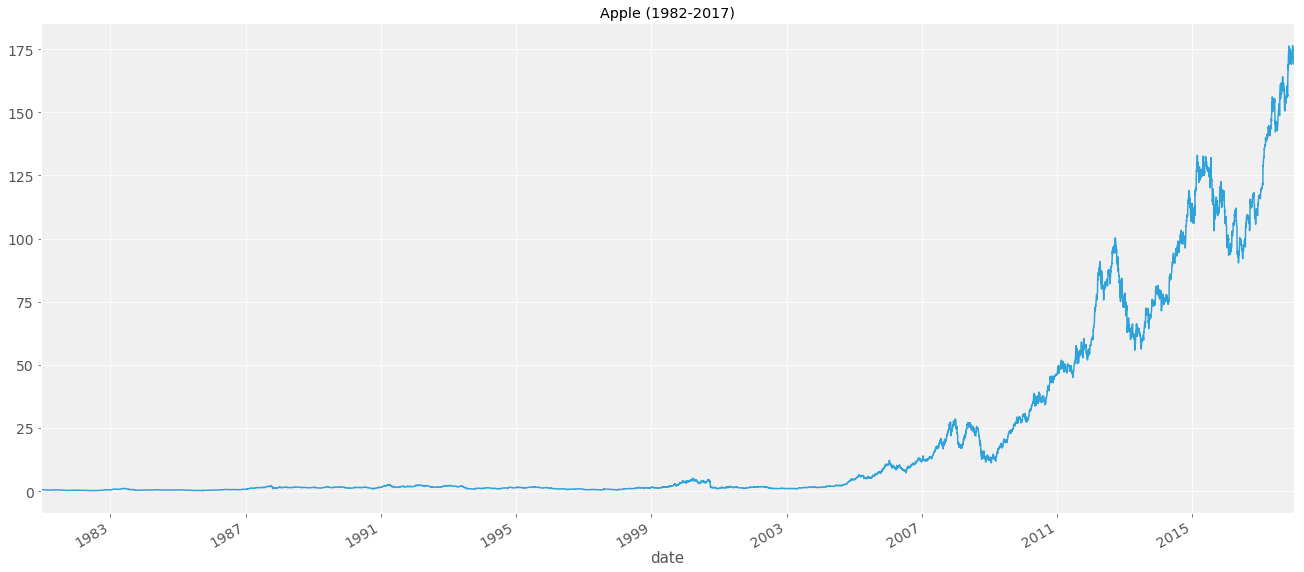

In [13]:
apple.plot(kind='line', x='date', y='Adjust Price', title='Apple (1982-2017)', legend=False, figsize=(20,10))

In [16]:
microsoft = pd.read_csv('microsoft.csv', index_col=0, header=0)
microsoft['PERMNO'] = microsoft.index
microsoft['date'] = microsoft['date'].apply(lambda x: datetime.datetime.strptime(str(x), '%Y%m%d'))
microsoft = microsoft.reset_index(drop=True)
microsoft.head()

,date,SHRCD,EXCHCD,SICCD,COMNAM,NAICS,DCLRDT,PAYDT,RCRDDT,DISTCD,DIVAMT,PRC,VOL,CFACPR,PERMNO
0,1986-03-06,nan,nan,nan,NaN,nan,nan,nan,nan,nan,nan,nan,nan,nan,10107
1,1986-03-10,nan,nan,nan,NaN,nan,nan,nan,nan,nan,nan,nan,nan,nan,10107
2,1986-03-13,11.000000,3.000000,7370.000000,MICROSOFT CORP,nan,nan,nan,nan,nan,nan,28.000000,3597701.000000,288.000000,10107
3,1986-03-14,11.000000,3.000000,7370.000000,MICROSOFT CORP,nan,nan,nan,nan,nan,nan,29.000000,1077151.000000,288.000000,10107
4,1986-03-17,11.000000,3.000000,7370.000000,MICROSOFT CORP,nan,nan,nan,nan,nan,nan,29.500000,465719.000000,288.000000,10107


In [17]:
# print('Before drop negative PRC, number of records:', microsoft.shape[0])
# microsoft = microsoft[microsoft['PRC'] >= 0]
# microsoft = microsoft.reset_index(drop=True)
# print('After drop negative PRC, number of records:', microsoft.shape[0])
microsoft['Adjust Price'] = abs(microsoft['PRC']) / microsoft['CFACPR']
microsoft['Adjust DIVAMT'] = microsoft['DIVAMT'] / microsoft['CFACPR']
microsoft.describe()

,SHRCD,EXCHCD,SICCD,NAICS,DCLRDT,PAYDT,RCRDDT,DISTCD,DIVAMT,PRC,VOL,CFACPR,PERMNO,Adjust Price,Adjust DIVAMT
count,8019.000000,8019.000000,8019.000000,3415.000000,65.000000,66.000000,66.000000,66.000000,66.000000,8019.000000,8019.000000,8019.000000,8021.000000,8019.000000,66.000000
mean,11.000000,3.000000,7370.000000,511210.000000,20082403.292308,20082565.984848,20082479.848485,1817.742424,0.212273,59.641615,31616682.744607,34.064597,10107.000000,22.669759,0.212273
std,0.000000,0.000000,0.000000,0.000000,67836.357351,69622.649479,69609.986519,1483.614674,0.368355,32.567708,32497177.936248,69.673307,0.000000,18.137001,0.368355
min,11.000000,3.000000,7370.000000,511210.000000,19870803.000000,19870918.000000,19870821.000000,1212.000000,0.000000,15.150000,1.000000,1.000000,10107.000000,0.090278,0.000000
25%,11.000000,3.000000,7370.000000,511210.000000,20050923.000000,20050983.000000,20050892.000000,1232.000000,0.090000,28.900000,2332056.000000,1.000000,10107.000000,2.841797,0.090000
50%,11.000000,3.000000,7370.000000,511210.000000,20090918.000000,20091060.000000,20090969.500000,1232.000000,0.130000,54.010000,26435624.000000,2.000000,10107.000000,25.680000,0.130000
75%,11.000000,3.000000,7370.000000,511210.000000,20130919.000000,20131137.000000,20131044.500000,1232.000000,0.280000,83.250000,50661870.000000,32.000000,10107.000000,30.925000,0.280000
max,11.000000,3.000000,7370.000000,511210.000000,20170919.000000,20171214.000000,20171116.000000,5523.000000,3.000000,179.937500,592924962.000000,288.000000,10107.000000,86.850000,3.000000


In [18]:
microsoft_div = microsoft[microsoft['DIVAMT'] > 0]
microsoft_div.head()

,date,SHRCD,EXCHCD,SICCD,COMNAM,NAICS,DCLRDT,PAYDT,RCRDDT,DISTCD,DIVAMT,PRC,VOL,CFACPR,PERMNO,Adjust Price,Adjust DIVAMT
4276,2003-02-19,11.000000,3.000000,7370.000000,MICROSOFT CORP,nan,20030116.000000,20030307.000000,20030221.000000,1212.000000,0.080000,24.530000,48129269.000000,1.000000,10107,24.530000,0.080000
4442,2003-10-15,11.000000,3.000000,7370.000000,MICROSOFT CORP,nan,20030912.000000,20031107.000000,20031017.000000,1252.000000,0.160000,29.070000,70462583.000000,1.000000,10107,29.070000,0.160000
4656,2004-08-23,11.000000,3.000000,7370.000000,MICROSOFT CORP,511210.000000,20040715.000000,20040914.000000,20040825.000000,1232.000000,0.080000,27.240000,40861974.000000,1.000000,10107,27.240000,0.080000
4715,2004-11-15,11.000000,3.000000,7370.000000,MICROSOFT CORP,511210.000000,20041109.000000,20041202.000000,20041117.000000,1272.000000,3.000000,27.390000,109942050.000000,1.000000,10107,27.390000,3.000000
4716,2004-11-15,11.000000,3.000000,7370.000000,MICROSOFT CORP,511210.000000,20040915.000000,20041202.000000,20041117.000000,1232.000000,0.080000,27.390000,109942050.000000,1.000000,10107,27.390000,0.080000


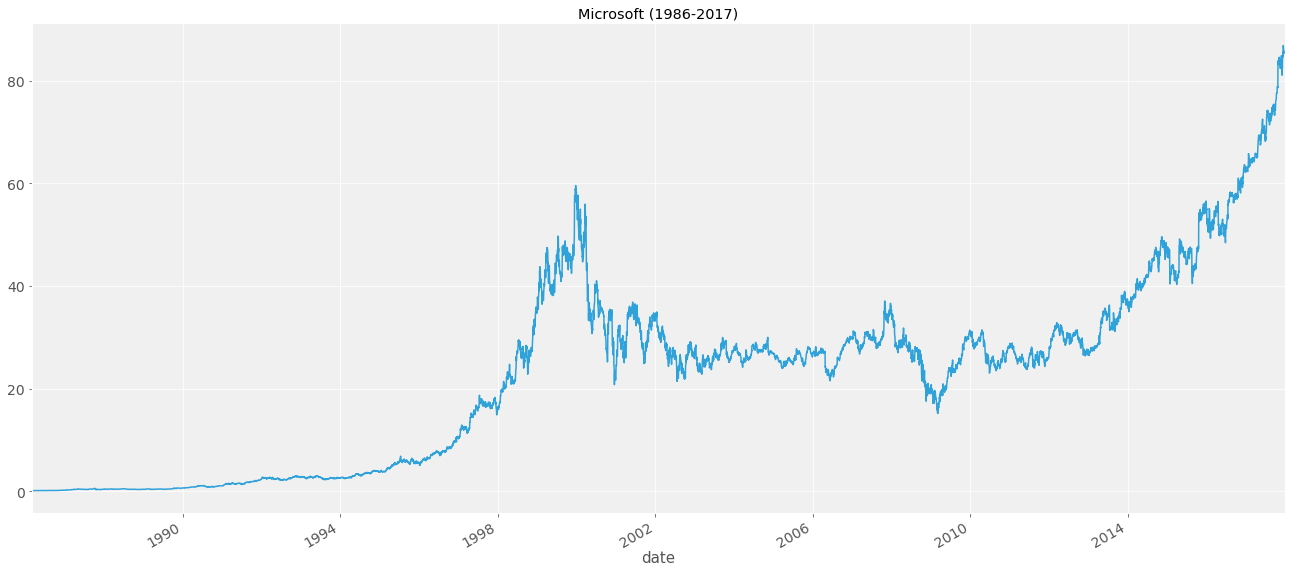

In [19]:
microsoft.plot(kind='line', x='date', y='Adjust Price', title='Microsoft (1986-2017)', legend=False, figsize=(20,10))

In [20]:
def Dividend_Period_Plot(df1, df2, increase=False):
    index = df2.index
    j = index[0]
    sample = df1.iloc[:j+1]
    ax = sample.plot(kind='line', x='date', y='Adjust Price', color='Blue', legend=False, figsize=(20,10))
    if increase:
        for i in tqdm(index[1:]):
            sample = df1.iloc[j:(i+1)]
            if sample['Adjust DIVAMT'].iloc[-1] > sample['Adjust DIVAMT'].iloc[0]:
                sample.plot(kind='line', x='date', y='Adjust Price', color='Red', legend=False, ax=ax)
            else:
                sample.plot(kind='line', x='date', y='Adjust Price', color='Blue', legend=False, ax=ax)
            j = i
    else:
        for i in tqdm(index[1:]):
            sample = df1.iloc[j:(i+1)]
            sample.plot(kind='line', x='date', y='Adjust Price', legend=False, ax=ax)
            j = i
    return ax

100%|██████████| 56/56 [00:00<00:00, 61.59it/s]


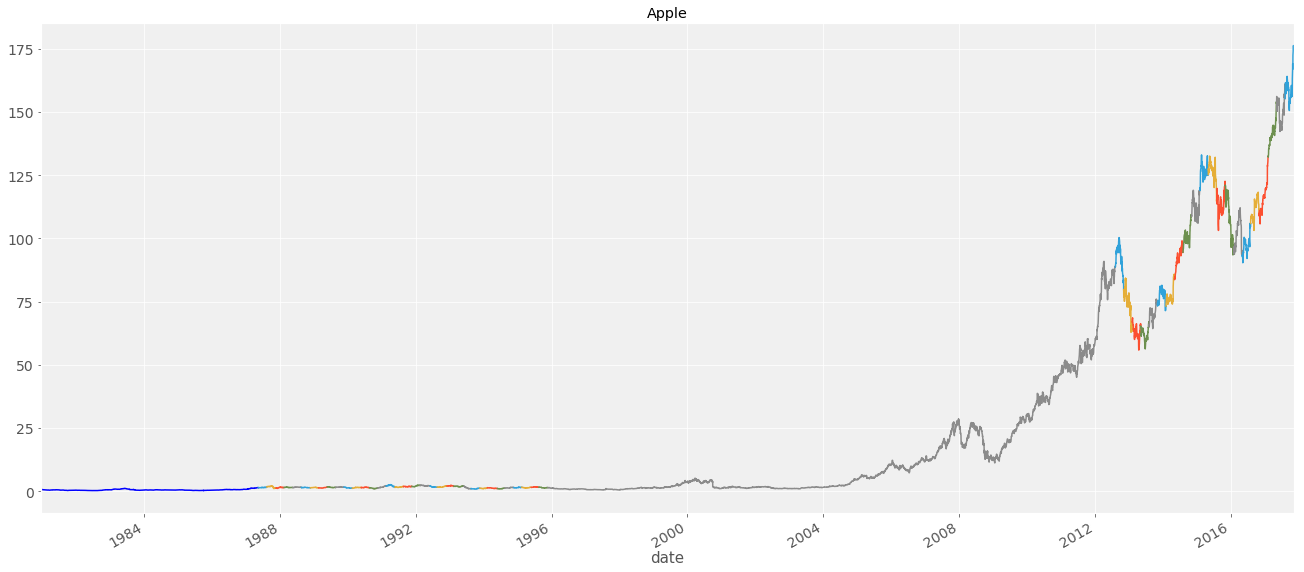

In [22]:
ax = Dividend_Period_Plot(apple, apple_div)
ax.set_title('Apple')

100%|██████████| 56/56 [00:00<00:00, 73.43it/s]


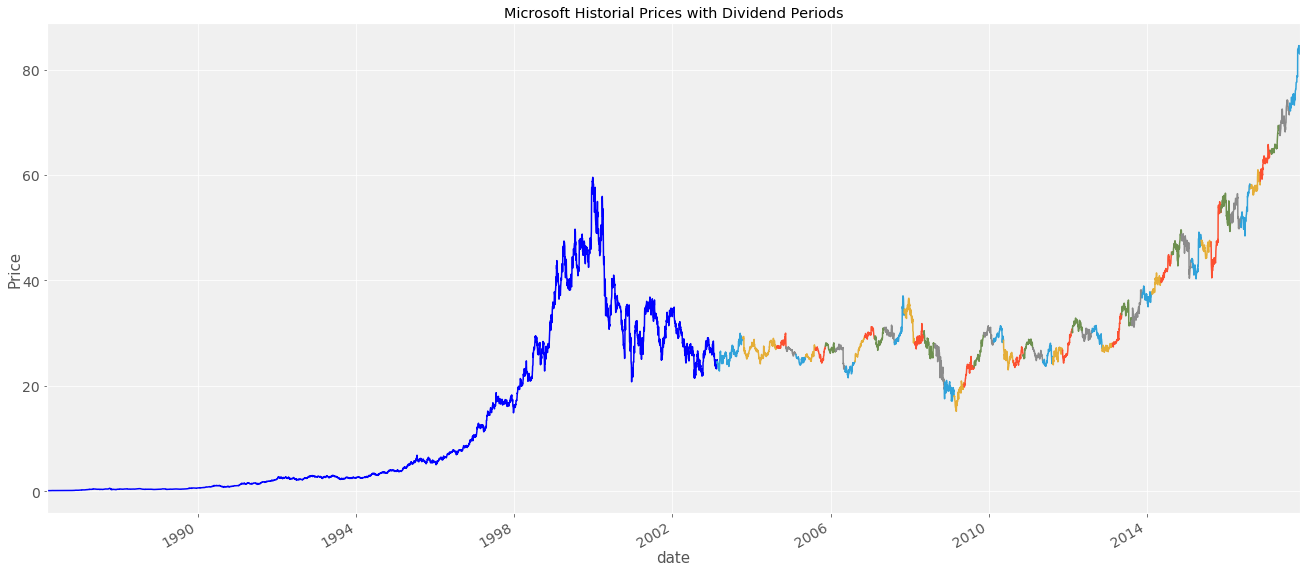

In [27]:
ax2 = Dividend_Period_Plot(microsoft, microsoft_div)
ax2.set_title('Microsoft Historial Prices with Dividend Periods')
ax2.set_ylabel('Price')

100%|██████████| 56/56 [00:00<00:00, 60.44it/s]


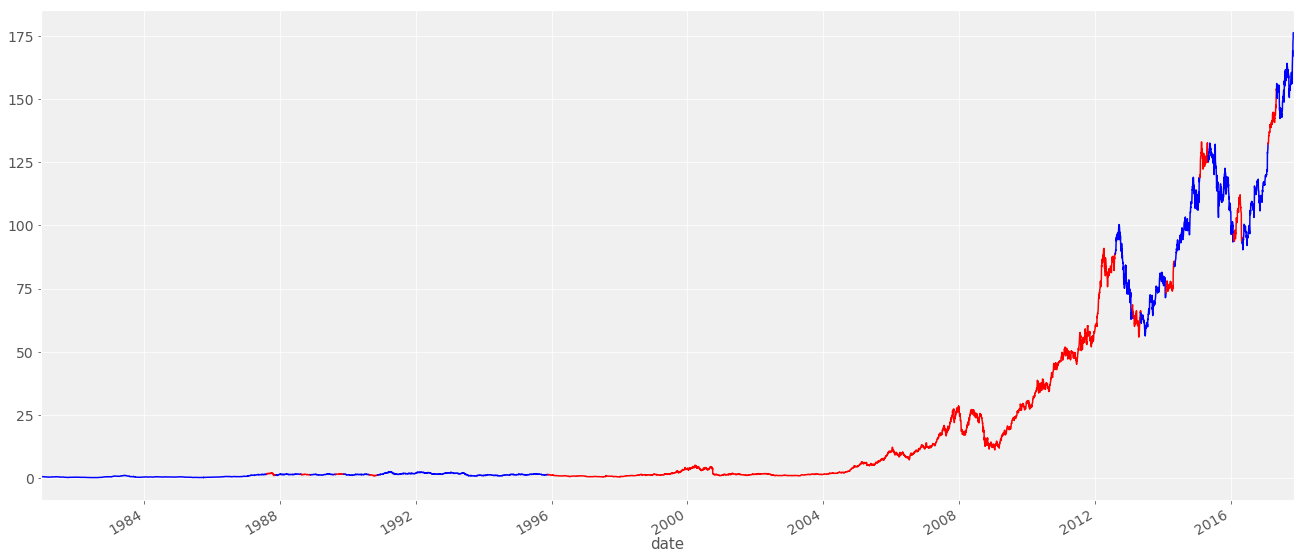

In [24]:
ax3 = Dividend_Period_Plot(apple, apple_div, increase=True)

100%|██████████| 56/56 [00:00<00:00, 64.67it/s]


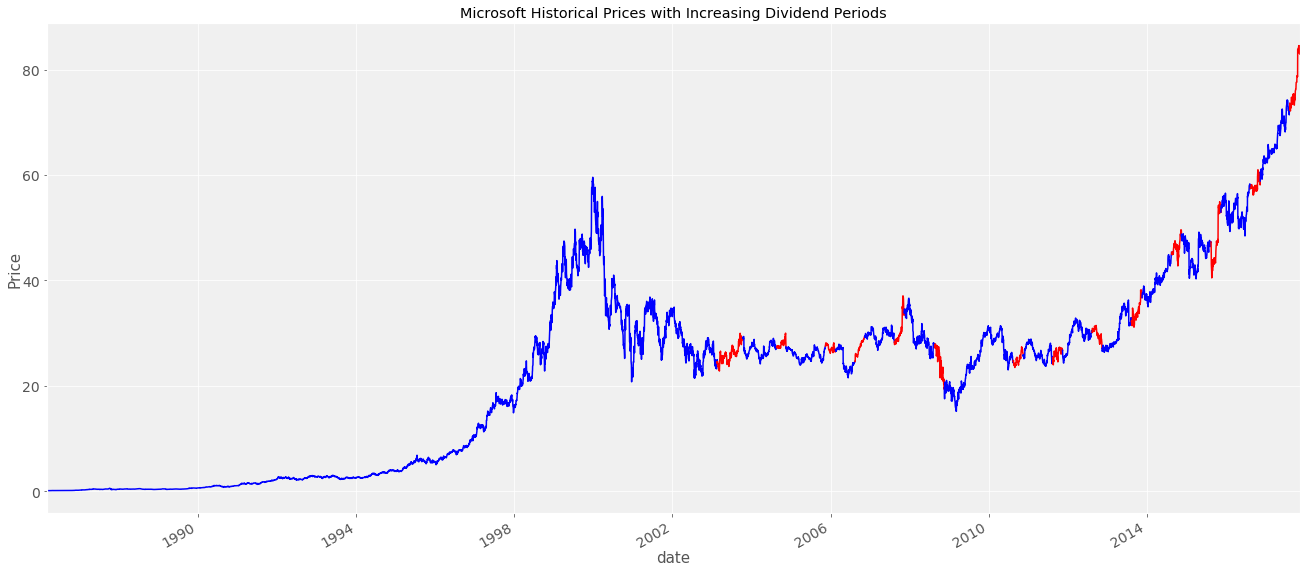

In [28]:
ax4 = Dividend_Period_Plot(microsoft, microsoft_div, increase=True)
ax4.set_title('Microsoft Historical Prices with Increasing Dividend Periods')
ax4.set_ylabel('Price')

In [29]:
def Dividend_Increase_Events(df1, df2):
    # df1: daily prices
    # df2: dividend events
    company = []
    DCLRDT = []
    EXDATE = []
    RCRDDT = []
    price_change = []
    dividend_change = []
    premium = []
    period = [0]
    N = df2.shape[0]
    for i in tqdm(np.arange(1, N)):
        if (i == 1) & (df2['PERMNO'].iloc[i] == df2['PERMNO'].iloc[i-1]):
            # dividend initiations: existing in the CRSP database for at least 6 quarters prior to announcing the dividend
            permno = df2['PERMNO'].iloc[0] # company's PERMNO code
            d0 = datetime.datetime.strptime(str(int(df2['DCLRDT'].iloc[0])), '%Y%m%d') # first declaration date
            d00 = df1[df1['PERMNO']==permno]['date'].iloc[0] # first date in the CRSP database 
            gap = (d0-d00).days
            if (gap >= 546):
                ex = df2['date'].iloc[0] # ex-dividend date
                re = datetime.datetime.strptime(str(int(df2['RCRDDT'].iloc[0])), '%Y%m%d') # record date
                index = df1[(df1['PERMNO'] == permno) & (df1['date'] == d0)].index[0]
                P1 = df1.loc[index]['Adjust Price'] # price on the declaration day
                P2 = df1.loc[index+1]['Adjust Price'] # price on the next day
                delta_P = P2 - P1
                D0 = df2['Adjust DIVAMT'].iloc[0]
                company.append(permno)
                price_change.append(delta_P)
                dividend_change.append(D0)
                DCLRDT.append(d0)
                EXDATE.append(ex)
                RCRDDT.append(re)
                premium.append(delta_P/D0)
        elif (df2['PERMNO'].iloc[i] != df2['PERMNO'].iloc[i-1]):
            # dividend initiations: existing in the CRSP database for at least 6 quarters prior to announcing the dividend
            permno = df2['PERMNO'].iloc[i] # company's PERMNO code
            d0 = datetime.datetime.strptime(str(int(df2['DCLRDT'].iloc[i])), '%Y%m%d') # first declaration date
            d00 = df1[df1['PERMNO']==permno]['date'].iloc[0] # first date in the CRSP database 
            gap = (d0-d00).days            
            if (gap >= 546):
                ex = df2['date'].iloc[i]
                re = datetime.datetime.strptime(str(int(df2['RCRDDT'].iloc[i])), '%Y%m%d')
                index = df1[(df1['PERMNO'] == permno) & (df1['date'] == d0)].index[0]
                P1 = df1.loc[index]['Adjust Price'] # price on the declaration day
                P2 = df1.loc[index+1]['Adjust Price'] # price on the next day
                delta_P = P2 - P1
                D0 = df2['Adjust DIVAMT'].iloc[i]
                company.append(permno)
                price_change.append(delta_P)
                dividend_change.append(D0)
                DCLRDT.append(d0)
                EXDATE.append(ex)
                RCRDDT.append(re)
                premium.append(delta_P/D0)

        elif (df2['PERMNO'].iloc[i] == df2['PERMNO'].iloc[i-1]):
            D1 = df2['Adjust DIVAMT'].iloc[i-1]
            D2 = df2['Adjust DIVAMT'].iloc[i]
            if (D2 > D1): # & ((D2/Price2 - D1/Price1) >= 0.00001):
                permno = df2['PERMNO'].iloc[i] # company's PERMNO code
                d1 = datetime.datetime.strptime(str(int(df2['DCLRDT'].iloc[i])), '%Y%m%d')
                ex = df2['date'].iloc[i]
                re = datetime.datetime.strptime(str(int(df2['RCRDDT'].iloc[0])), '%Y%m%d')
                index = df1[(df1['PERMNO'] == permno) & (df1['date'] == d1)].index[0]
                P1 = df1.loc[index]['Adjust Price'] # price on the declaration day
                P2 = df1.loc[index+1]['Adjust Price'] # price on the next day
                delta_P = P2 - P1
                delta_D = D2 - D1
                company.append(permno)
                DCLRDT.append(d1)
                EXDATE.append(ex)
                RCRDDT.append(re)
                price_change.append(delta_P)
                dividend_change.append(delta_D)
                premium.append(delta_P / delta_D)

    df = {'date': EXDATE, 'PERMNO': company, 'DCLRDT': DCLRDT, 'RCRDDT': RCRDDT,
         'Price Change': price_change, 'Dividend Change': dividend_change, 'Premium': premium}
    df = pd.DataFrame(df, columns=['date', 'PERMNO', 'DCLRDT', 'RCRDDT', 'Price Change', 'Dividend Change', 'Premium'])
    return df

In [30]:
apple_output = Dividend_Increase_Events(apple, apple_div)
apple_output

100%|██████████| 56/56 [00:00<00:00, 1684.95it/s]


,date,PERMNO,DCLRDT,RCRDDT,Price Change,Dividend Change,Premium
0,1987-05-11,14593,1987-04-22,1987-05-15,0.031250,0.002143,14.583333
1,1987-11-17,14593,1987-11-11,1987-05-15,0.053571,0.000714,75.000000
2,1988-11-21,14593,1988-11-09,1987-05-15,0.008929,0.000714,12.500000
3,1989-11-17,14593,1989-11-09,1987-05-15,0.026786,0.000357,75.000000
4,1990-11-16,14593,1990-11-06,1987-05-15,-0.008929,0.000357,-25.000000
5,2012-08-09,14593,2012-07-24,1987-05-15,-3.707144,0.374286,-9.904584
6,2013-05-09,14593,2013-04-23,1987-05-15,-0.095427,0.057143,-1.669975
7,2014-05-08,14593,2014-04-23,1987-05-15,6.145717,0.034286,179.250083
8,2015-05-07,14593,2015-04-27,1987-05-15,-2.089990,0.050000,-41.799800
9,2016-05-05,14593,2016-04-26,1987-05-15,-6.530000,0.050000,-130.600000


In [31]:
microsoft_output = Dividend_Increase_Events(microsoft, microsoft_div)
microsoft_output

100%|██████████| 56/56 [00:00<00:00, 1418.19it/s]


,date,PERMNO,DCLRDT,RCRDDT,Price Change,Dividend Change,Premium
0,2003-02-19,10107,2003-01-16,2003-02-21,-1.945000,0.080000,-24.312500
1,2004-11-15,10107,2004-11-09,2003-02-21,-0.040000,2.920000,-0.013699
2,2006-02-15,10107,2005-12-14,2003-02-21,-0.170000,0.010000,-17.000000
3,2006-11-14,10107,2006-09-13,2003-02-21,0.350000,0.010000,35.000000
4,2007-11-13,10107,2007-09-12,2003-02-21,0.230000,0.010000,23.000000
5,2008-11-18,10107,2008-09-22,2003-02-21,0.040000,0.020000,2.000000
6,2010-11-16,10107,2010-09-21,2003-02-21,-0.540000,0.030000,-18.000000
7,2011-11-15,10107,2011-09-20,2003-02-21,-0.990000,0.040000,-24.750000
8,2012-11-13,10107,2012-09-18,2003-02-21,-0.123000,0.030000,-4.100000
9,2013-11-19,10107,2013-09-19,2003-02-21,-0.849000,0.050000,-16.980000


In [36]:
def Dividend_Increase_Strategy(df1, df2):
    # df1: daily prices
    # df2: dividend increase events
    N = df2.shape[0]
    LONG = []
    long_price = []
    SHORT = []
    short_price = []
    EXDATE = []
    dividend = []
    RETURN = []
    for i in range(N):
        permno = df2['PERMNO'].iloc[i] # the stock name
        long = df2['DCLRDT'].iloc[i] # long the stock on the declaration day
        P1 = df1[(df1['PERMNO'] == permno) & (df1['date'] == long)]['Adjust Price'].iloc[0]
        ex = df2['date'].iloc[i] # ex-dividend date
        re = df2['DCLRDT'].iloc[i] # record date
        index = df1[(df1['PERMNO'] == permno) & (df1['date'] == ex)].index[0]
        while (df1.loc[index]['date'] <= re):
            index = index + 1
        short = df1.loc[index]['date'] # short the stock one day after the record date
        P2 = df1[(df1['PERMNO'] == permno) & (df1['date'] == short)]['Adjust Price'].iloc[0]
        D = df1[(df1['PERMNO'] == permno) & (df1['date'] == ex)]['Adjust DIVAMT'].iloc[0]
        LONG.append(long)
        long_price.append(P1)
        SHORT.append(short)
        short_price.append(P2)
        EXDATE.append(ex)
        dividend.append(D)
        RETURN.append((P2+D-P1)/P1)
    
    df = {'date': EXDATE, 'Long Date': LONG, 'Long Price': long_price, 'Short Date': SHORT, 
          'Short Price': short_price, 'Dividend': dividend, 'Return': RETURN}
    df = pd.DataFrame(df, columns=['date', 'Long Date', 'Long Price', 'Short Date', 'Short Price', 'Dividend', 'Return'])
    return df


In [37]:
apple_strategy = Dividend_Increase_Strategy(apple, apple_output)
apple_strategy

,date,Long Date,Long Price,Short Date,Short Price,Dividend,Return
0,1987-05-11,1987-04-22,1.325893,1987-05-11,1.375000,0.002143,0.038653
1,1987-11-17,1987-11-11,1.330357,1987-11-17,1.250000,0.002857,-0.058255
2,1988-11-21,1988-11-09,1.401786,1988-11-21,1.308036,0.003571,-0.064331
3,1989-11-17,1989-11-09,1.642857,1989-11-17,1.598214,0.003929,-0.024783
4,1990-11-16,1990-11-06,1.196429,1990-11-16,1.254464,0.004286,0.052090
5,2012-08-09,2012-07-24,85.845711,2012-08-09,88.675711,0.378571,0.037376
6,2013-05-09,2013-04-23,58.018571,2013-05-09,65.252856,0.435714,0.132199
7,2014-05-08,2014-04-23,74.964286,2014-05-08,83.998570,0.470000,0.126784
8,2015-05-07,2015-04-27,132.649990,2015-05-07,125.260000,0.520000,-0.051790
9,2016-05-05,2016-04-26,104.350000,2016-05-05,93.240000,0.570000,-0.101006


In [38]:
microsoft_strategy = Dividend_Increase_Strategy(microsoft, microsoft_output)
microsoft_strategy

,date,Long Date,Long Price,Short Date,Short Price,Dividend,Return
0,2003-02-19,2003-01-16,27.675000,2003-02-19,24.530000,0.080000,-0.110750
1,2004-11-15,2004-11-09,29.770000,2004-11-15,27.390000,3.000000,0.020826
2,2006-02-15,2005-12-14,27.090000,2006-02-15,26.880000,0.090000,-0.004430
3,2006-11-14,2006-09-13,25.980000,2006-11-14,29.228500,0.100000,0.128888
4,2007-11-13,2007-09-12,28.930000,2007-11-13,34.460000,0.110000,0.194953
5,2008-11-18,2008-09-22,25.400000,2008-11-18,19.620000,0.130000,-0.222441
6,2010-11-16,2010-09-21,25.150000,2010-11-16,25.810000,0.160000,0.032604
7,2011-11-15,2011-09-20,26.980000,2011-11-15,26.740000,0.200000,-0.001483
8,2012-11-13,2012-09-18,31.175000,2012-11-13,27.089500,0.230000,-0.123673
9,2013-11-19,2013-09-19,33.640000,2013-11-19,36.740000,0.280000,0.100476


In [39]:
risk_free = pd.read_csv('TBills.csv', header=0)
risk_free = risk_free[['date', 'RF']]
risk_free['date'] = risk_free['date'].apply(lambda x: datetime.datetime.strptime(str(x), '%Y%m%d'))
risk_free['RF'] = risk_free['RF'] / 252
risk_free.head()

,date,RF
0,1963-07-01,0.000048
1,1963-07-02,0.000048
2,1963-07-03,0.000048
3,1963-07-05,0.000048
4,1963-07-08,0.000048


In [40]:
def Strategy_Performance(df1, df2, df3):
    # df1: historical prices
    # df2: strategy
    # df3: risk free rates
    LONG = df2['Long Date']
    SHORT = df2['Short Date']
    df3 = df3[(df3['date'] >= LONG.iloc[0]) & (df3['date'] <= df1['date'].iloc[-1])]
    N = df2.shape[0]
    M = df3.shape[0]
    RETURN = []
    date = []
    j = 0
    for i in range(N):
        long = LONG.iloc[i]
        short = SHORT.iloc[i]
        horizon = np.busday_count(long, short)
        daily_return = (1+df2['Return'].iloc[i])**(1/horizon)-1
        while (df3['date'].iloc[j] < short):
            RETURN.append(daily_return)
            date.append(df3['date'].iloc[j])
            j = j + 1
        if (i < N-1):
            while (df3['date'].iloc[j] >= short) & (df3['date'].iloc[j] < LONG.iloc[i+1]):
                RETURN.append(df3['RF'].iloc[j])
                date.append(df3['date'].iloc[j])
                j = j + 1
        else:
            while (j < M-1) & (df3['date'].iloc[j] >= short):
                RETURN.append(df3['RF'].iloc[j])
                date.append(df3['date'].iloc[j])
                j = j + 1
    
    df = {'date':date, 'Return': RETURN}
    df = pd.DataFrame(df, columns = ['date', 'Return'])
    return df
    

In [41]:
apple_portfolio = risk_free[(risk_free['date'] >= apple_strategy['Long Date'].iloc[0]) & (risk_free['date'] <= apple['date'].iloc[-1])]
apple_portfolio = apple_portfolio.reset_index(drop=True)
apple_portfolio['Return'] = apple_portfolio['RF']
apple_portfolio['Return'].iloc[:-1] = np.array(Strategy_Performance(apple, apple_strategy, risk_free)['Return'])
apple_portfolio['Return'].iloc[-1] = np.nan
apple_portfolio['Cumulative Return'] = np.cumprod(apple_portfolio['Return']+1)-1
apple_portfolio['Cumulative RF'] = np.cumprod(apple_portfolio['RF']+1)-1
apple_portfolio.head()

/Users/yunkunxu/miniconda3/lib/python3.6/site-packages/pandas/core/indexing.py:179: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  self._setitem_with_indexer(indexer, value)


,date,RF,Return,Cumulative Return,Cumulative RF
0,1987-04-22,0.000083,0.002922,0.002922,0.000083
1,1987-04-23,0.000083,0.002922,0.005852,0.000167
2,1987-04-24,0.000083,0.002922,0.008790,0.000250
3,1987-04-27,0.000083,0.002922,0.011738,0.000333
4,1987-04-28,0.000083,0.002922,0.014693,0.000417


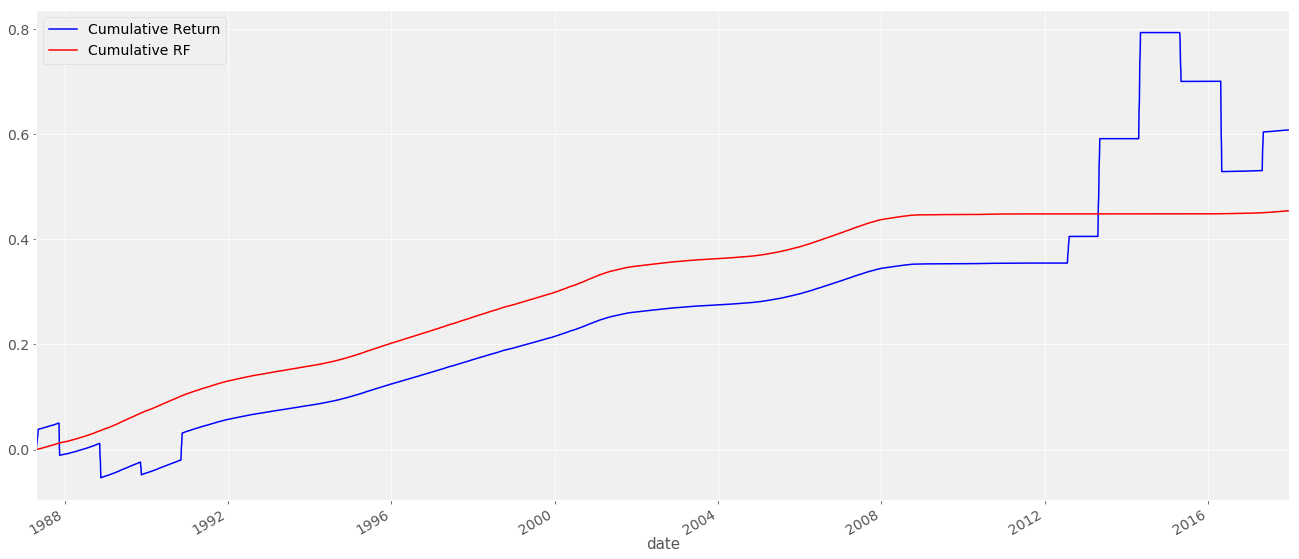

In [42]:
ax = apple_portfolio.plot(kind='line', x='date', y='Cumulative Return', color='Blue', figsize=(20,10))
apple_portfolio.plot(kind='line', x='date', y='Cumulative RF', color='Red', ax=ax)


In [43]:
microsoft_portfolio = risk_free[(risk_free['date'] >= microsoft_strategy['Long Date'].iloc[0]) & (risk_free['date'] <= microsoft['date'].iloc[-1])]
microsoft_portfolio = microsoft_portfolio.reset_index(drop=True)
microsoft_portfolio['Return'] = microsoft_portfolio['RF']
microsoft_portfolio['Return'].iloc[:-1] = np.array(Strategy_Performance(microsoft, microsoft_strategy, risk_free)['Return'])
microsoft_portfolio['Return'].iloc[-1] = np.nan
microsoft_portfolio['Cumulative Return'] = np.cumprod(microsoft_portfolio['Return']+1)-1
microsoft_portfolio['Cumulative RF'] = np.cumprod(microsoft_portfolio['RF']+1)-1
microsoft_portfolio.head()

/Users/yunkunxu/miniconda3/lib/python3.6/site-packages/pandas/core/indexing.py:179: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  self._setitem_with_indexer(indexer, value)


,date,RF,Return,Cumulative Return,Cumulative RF
0,2003-01-16,0.000020,-0.004879,-0.004879,0.000020
1,2003-01-17,0.000020,-0.004879,-0.009734,0.000040
2,2003-01-21,0.000020,-0.004879,-0.014565,0.000060
3,2003-01-22,0.000020,-0.004879,-0.019373,0.000079
4,2003-01-23,0.000020,-0.004879,-0.024157,0.000099


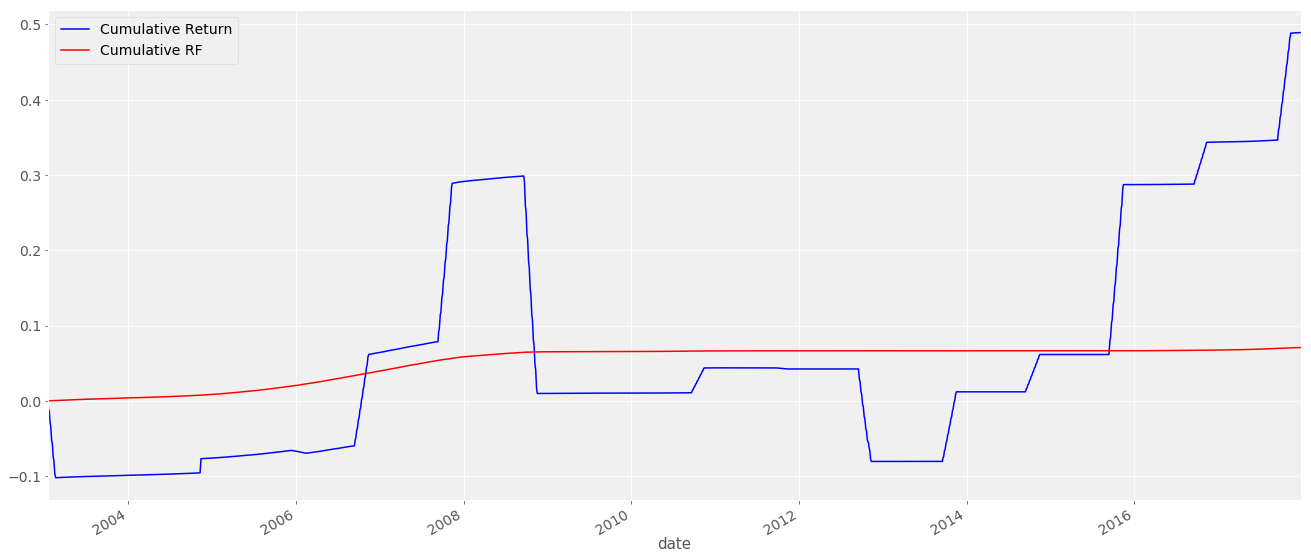

In [44]:
ax = microsoft_portfolio.plot(kind='line', x='date', y='Cumulative Return', color='Blue', figsize=(20,10))
microsoft_portfolio.plot(kind='line', x='date', y='Cumulative RF', color='Red', ax=ax)


In [45]:
long_portfolio = risk_free[(risk_free['date'] >= apple_strategy['Long Date'].iloc[0]) & (risk_free['date'] <= apple['date'].iloc[-1])]
long_portfolio = long_portfolio.reset_index(drop=True)
long_portfolio['Price'] = np.array(apple[apple['date'] >= apple_strategy['Long Date'].iloc[0]]['Adjust Price'])
long_portfolio['Daily Return'] = np.diff(long_portfolio['Price']) / long_portfolio['Price'][:-1]
long_portfolio['Cumulative Return'] = np.cumprod(long_portfolio['Daily Return']+1)-1
long_portfolio['Cumulative RF'] = np.cumprod(long_portfolio['RF']+1)-1
long_portfolio.head()

,date,RF,Price,Daily Return,Cumulative Return,Cumulative RF
0,1987-04-22,0.000083,1.325893,0.023569,0.023569,0.000083
1,1987-04-23,0.000083,1.357143,-0.016447,0.006734,0.000167
2,1987-04-24,0.000083,1.334821,0.003344,0.010101,0.000250
3,1987-04-27,0.000083,1.339286,0.026667,0.037037,0.000333
4,1987-04-28,0.000083,1.375000,0.009740,0.047138,0.000417


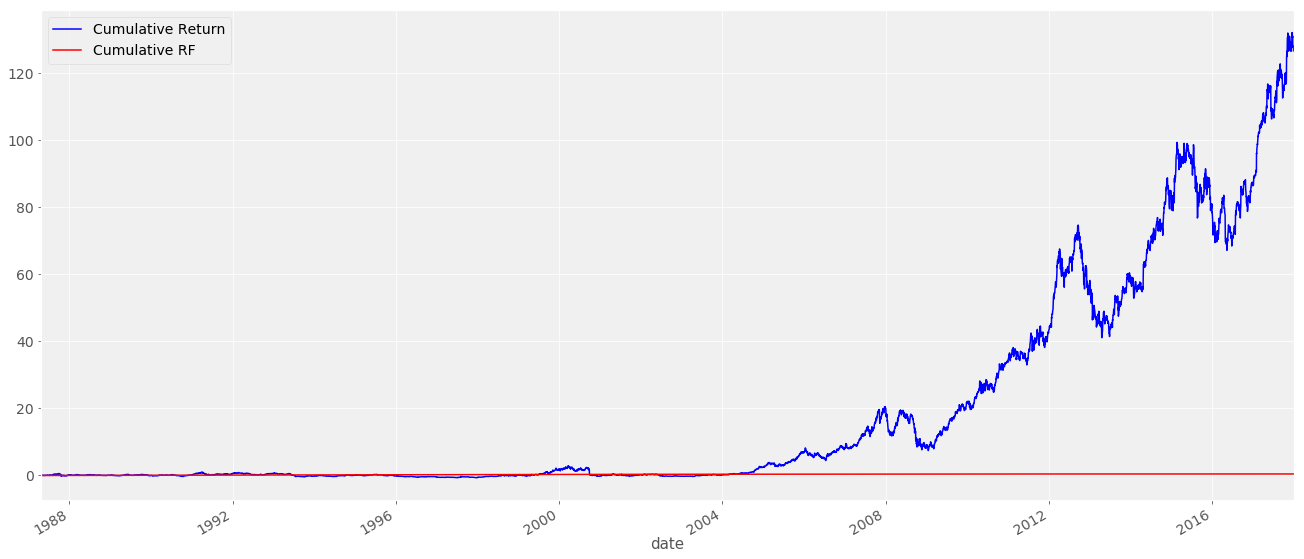

In [46]:
ax = long_portfolio.plot(kind='line', x='date', y='Cumulative Return', color='Blue', figsize=(20,10))
long_portfolio.plot(kind='line', x='date', y='Cumulative RF', color='Red', ax=ax)


In [47]:
long_microsoft = risk_free[(risk_free['date'] >= microsoft_strategy['Long Date'].iloc[0]) & (risk_free['date'] <= microsoft['date'].iloc[-1])]
long_microsoft = long_microsoft.reset_index(drop=True)

In [48]:
test = microsoft[microsoft['date'] >= microsoft_strategy['Long Date'].iloc[0]]
test.head(10)

,date,SHRCD,EXCHCD,SICCD,COMNAM,NAICS,DCLRDT,PAYDT,RCRDDT,DISTCD,DIVAMT,PRC,VOL,CFACPR,PERMNO,Adjust Price,Adjust DIVAMT
4254,2003-01-16,11.000000,3.000000,7370.000000,MICROSOFT CORP,nan,nan,nan,nan,nan,nan,55.350000,43127976.000000,2.000000,10107,27.675000,nan
4255,2003-01-17,11.000000,3.000000,7370.000000,MICROSOFT CORP,nan,nan,nan,nan,nan,nan,51.460000,78386848.000000,2.000000,10107,25.730000,nan
4256,2003-01-21,11.000000,3.000000,7370.000000,MICROSOFT CORP,nan,nan,nan,nan,nan,nan,51.330000,44097516.000000,2.000000,10107,25.665000,nan
4257,2003-01-22,11.000000,3.000000,7370.000000,MICROSOFT CORP,nan,nan,nan,nan,nan,nan,51.000000,44036294.000000,2.000000,10107,25.500000,nan
4258,2003-01-23,11.000000,3.000000,7370.000000,MICROSOFT CORP,nan,nan,nan,nan,nan,nan,52.280000,36480103.000000,2.000000,10107,26.140000,nan
4259,2003-01-24,11.000000,3.000000,7370.000000,MICROSOFT CORP,nan,nan,nan,nan,nan,nan,49.850000,52305214.000000,2.000000,10107,24.925000,nan
4260,2003-01-27,11.000000,3.000000,7370.000000,MICROSOFT CORP,nan,nan,nan,nan,nan,nan,49.170000,57779606.000000,2.000000,10107,24.585000,nan
4261,2003-01-28,11.000000,3.000000,7370.000000,MICROSOFT CORP,nan,nan,nan,nan,nan,nan,48.820000,43554514.000000,2.000000,10107,24.410000,nan
4262,2003-01-29,11.000000,3.000000,7370.000000,MICROSOFT CORP,nan,nan,nan,nan,nan,nan,49.910000,54112019.000000,2.000000,10107,24.955000,nan
4263,2003-01-30,11.000000,3.000000,7370.000000,MICROSOFT CORP,nan,nan,nan,nan,nan,nan,48.240000,44525754.000000,2.000000,10107,24.120000,nan


In [49]:
long_microsoft['Price'] = np.array(test.drop(test.index[5])['Adjust Price'])
long_microsoft['Daily Return'] = np.diff(long_microsoft['Price']) / long_microsoft['Price'][:-1]
long_microsoft['Cumulative Return'] = np.cumprod(long_microsoft['Daily Return']+1)-1
long_microsoft['Cumulative RF'] = np.cumprod(long_microsoft['RF']+1)-1
long_microsoft.head()

,date,RF,Price,Daily Return,Cumulative Return,Cumulative RF
0,2003-01-16,0.000020,27.675000,-0.070280,-0.070280,0.000020
1,2003-01-17,0.000020,25.730000,-0.002526,-0.072629,0.000040
2,2003-01-21,0.000020,25.665000,-0.006429,-0.078591,0.000060
3,2003-01-22,0.000020,25.500000,0.025098,-0.055465,0.000079
4,2003-01-23,0.000020,26.140000,-0.059487,-0.111653,0.000099


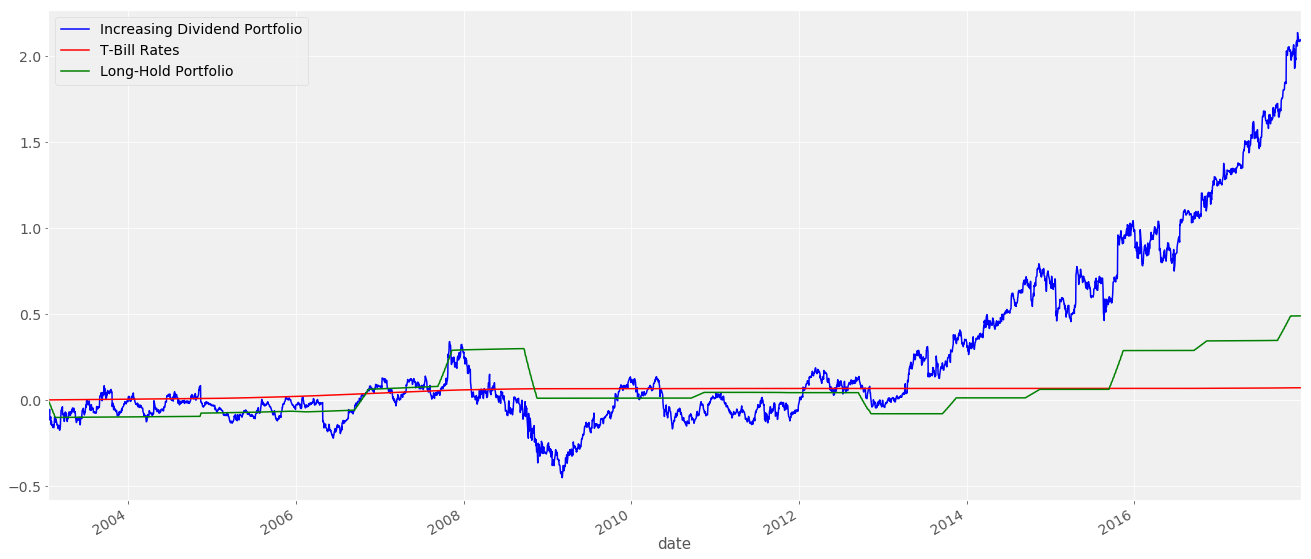

In [51]:
ax = long_microsoft.plot(kind='line', x='date', y='Cumulative Return', color='Blue', figsize=(20,10))
long_microsoft.plot(kind='line', x='date', y='Cumulative RF', color='Red', ax=ax)
microsoft_portfolio.plot(kind='line', x='date', y='Cumulative Return', color='Green', ax=ax)
ax.legend(['Increasing Dividend Portfolio', 'T-Bill Rates', 'Long-Hold Portfolio'])

In [272]:
def Portfolio_Implement(df1, df21, df22, df3, fund):
    # df1: historical prices
    # df21: strategy with all dividends increase announcements sorted by long date
    # df22: strategy with all dividends increase announcements sorted by short date
    # df3: risk free rates
    # fund: the initial value
    LONG = np.array(df21['Long Date'])
    SHORT = np.array(df22['Short Date'])
    df3 = df3[(df3['date'] >= LONG[0]) & (df3['date'] <= df1['date'].iloc[-1])]
    N = df21.shape[0]
    #M = df3.shape[0]
    i = 0
    j = 0
    NAV = [fund]
    company = []
    weight = fund/df21['Long Price'].iloc[0]
    proceed = 0
    date = [LONG[0]]

    while (i < N):
        long = LONG[i]
        if (i > 0):
            rf = np.array(df3[(df3['date'] > short) & (df3['date'] < long)]['RF'])
            proceed = proceed*(np.cumprod(rf+1)[-1])
            print('proceed until next long', proceed)
    
        if company is None:
            company = [df21['PERMNO'].iloc[i]]
            nav = proceed
            weight = nav/df21['Long Price'].iloc[i]
            NAV.append(proceed)
            date.append(long)
            
        else:
            company.append(df21['PERMNO'].iloc[i])
            price = np.array(df1[(df1['PERMNO'].isin(company)) & (df1['date']==long)]['Adjust Price'])
            print(price)
            nav = np.dot(price, (weight+np.zeros(len(company))))
            print(nav)
            
        print('i=',i)
        short = SHORT[i] # the short date
        short_stock = df22['PERMNO'].iloc[i] # the stock to short 
        j = i + 1
        if j < N:
            while (LONG[j] < short):
                company.append(df21['PERMNO'].iloc[j])
                weight = weight/(len(company))
                price = np.array(df1[(df1['PERMNO'].isin(company)) & (df1['date']==LONG[j])]['Adjust Price'])
                nav = np.dot(price, (weight+np.zeros(len(company))))
                print('nav with more coming :', nav)
                NAV.append(nav)
                date.append(LONG.iloc[j])
                j = j + 1
        
        # short the stock and invest the proceed earning RF
        print('company: ', company)
        price = np.array(df1[(df1['PERMNO'].isin(company)) & (df1['date']==short)]['Adjust Price'])
        print('short price', price)
        print('weight', weight)
        print('dividend', df22['Dividend'].iloc[i])
        nav = np.dot(price, (weight+np.zeros(len(company)))) + weight*df22['Dividend'].iloc[i]
        print('nav after short:', nav)
        company = company.remove(short_stock) # remove the stock from the portfolio
        proceed = weight*df22['Short Price'].iloc[i] + weight*df22['Dividend'].iloc[i]
        print('proceed after sell', proceed)
        NAV.append(nav)
        date.append(short)
        i = j

    
    
    df = {'date':date, 'NAV': NAV}
    print(len(date), len(NAV))
    df = pd.DataFrame(df, columns = ['date', 'NAV'])
    return df
    

In [273]:
D1 = pd.concat([apple, microsoft])
D1 = D1.drop(D1.index[4714]) # ignore the second dividend on the same day

In [274]:
temp1 = apple_strategy[['Long Date', 'Long Price']]
temp1['PERMNO'] = 14593
temp2 = microsoft_strategy[['Long Date', 'Long Price']]
temp2['PERMNO'] = 10107           
D21 = pd.concat([temp1, temp2])
D21 = D21.sort_values('Long Date')
D21 = D21.reset_index(drop=True)
D21

/Users/yunkunxu/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  
/Users/yunkunxu/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  after removing the cwd from sys.path.


,Long Date,Long Price,PERMNO
0,1987-04-22,1.325893,14593
1,1987-11-11,1.330357,14593
2,1988-11-09,1.401786,14593
3,1989-11-09,1.642857,14593
4,1990-11-06,1.196429,14593
5,2004-11-09,29.770000,10107
6,2005-12-14,27.090000,10107
7,2006-09-13,25.980000,10107
8,2007-09-12,28.930000,10107
9,2008-09-22,25.400000,10107


In [275]:
temp1 = apple_strategy[['Short Date', 'Short Price', 'Dividend']]
temp1['PERMNO'] = 14593
temp2 = microsoft_strategy[['Short Date', 'Short Price', 'Dividend']]
temp2['PERMNO'] = 10107      
D22 = pd.concat([temp1, temp2])
D22 = D22.sort_values('Short Date')
D22 = D22.reset_index(drop=True)
D22

/Users/yunkunxu/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  
/Users/yunkunxu/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  after removing the cwd from sys.path.


,Short Date,Short Price,Dividend,PERMNO
0,1987-05-11,1.375000,0.002143,14593
1,1987-11-17,1.250000,0.002857,14593
2,1988-11-21,1.308036,0.003571,14593
3,1989-11-17,1.598214,0.003929,14593
4,1990-11-16,1.254464,0.004286,14593
5,2004-11-15,27.390000,3.000000,10107
6,2006-02-15,26.880000,0.090000,10107
7,2006-11-14,29.228500,0.100000,10107
8,2007-11-13,34.460000,0.110000,10107
9,2008-11-18,19.620000,0.130000,10107


In [261]:
Portfolio = Portfolio_Implement(D1, D21, D22, risk_free, fund=1)

[ 1.326]
1.0
i= 0
company:  [14593]
short price [ 1.375]
weight 0.754208754209
dividend 0.00214285714286
nav after short: 1.03865319865
proceed after sell 1.03865319865
proceed until next long 1.0502951351
i= 1
company:  [14593]
short price [ 1.25]
weight 0.789483591486
dividend 0.00285714285714
nav after short: 0.989110156761
proceed after sell 0.989110156761
proceed until next long 1.01155611233
i= 2
company:  [14593]
short price [ 1.308]
weight 0.721619647015
dividend 0.00357142857143
nav after short: 0.946481483452
proceed after sell 0.946481483452
proceed until next long 0.976070840245
i= 3
company:  [14593]
short price [ 1.598]
weight 0.594130076671
dividend 0.00392857142857
nav after short: 0.951881258551
proceed after sell 0.951881258551
proceed until next long 0.97990382733
i= 4
company:  [14593]
short price [ 1.254]
weight 0.819024094485
dividend 0.00428571428571
nav after short: 1.03094657893
proceed after sell 1.03094657893
proceed until next long 1.27919564987
i= 5
company

In [262]:
Portfolio

,date,NAV
0,1987-04-22,1.000000
1,1987-05-11,1.038653
2,1987-11-11,1.050295
3,1987-11-17,0.989110
4,1988-11-09,1.011556
5,1988-11-21,0.946481
6,1989-11-09,0.976071
7,1989-11-17,0.951881
8,1990-11-06,0.979904
9,1990-11-16,1.030947


In [270]:
benchmark = risk_free[(risk_free['date'] >= Portfolio['date'].iloc[0]) & (risk_free['date'] <= Portfolio['date'].iloc[-1])]
benchmark['NAV'] = np.cumprod(1+benchmark['RF'])
benchmark = benchmark.reset_index(drop=True)
benchmark.head()

/Users/yunkunxu/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  


,date,RF,NAV
0,1987-04-22,0.000083,1.000083
1,1987-04-23,0.000083,1.000167
2,1987-04-24,0.000083,1.000250
3,1987-04-27,0.000083,1.000333
4,1987-04-28,0.000083,1.000417


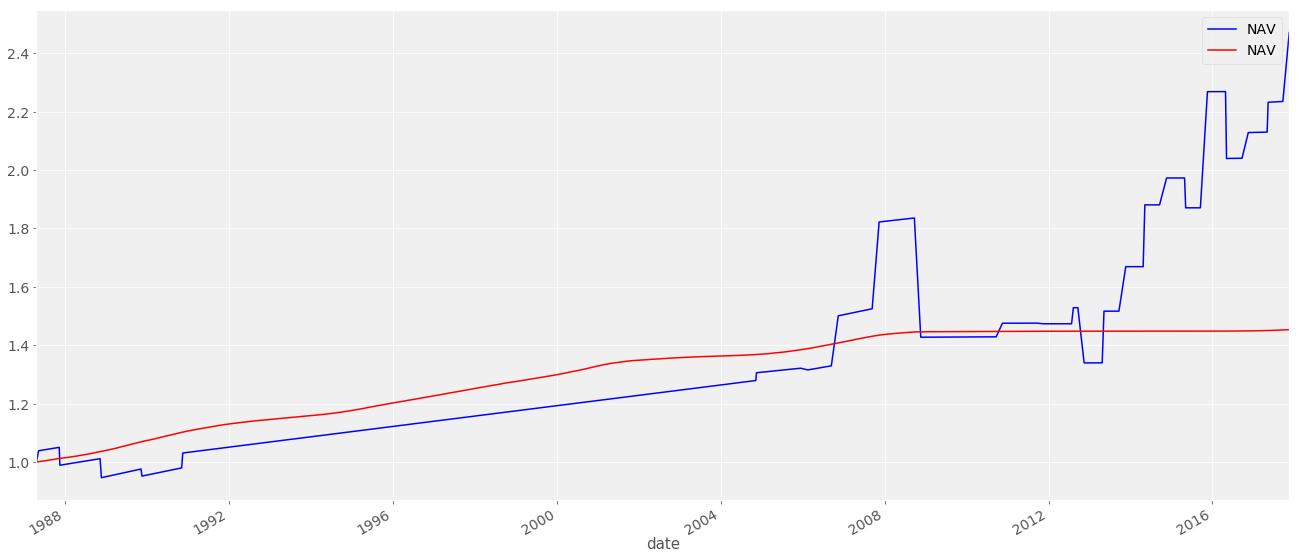

In [271]:
ax = Portfolio.plot(kind='line', x='date', y='NAV', color='Blue', figsize=(20,10))
benchmark.plot(kind='line', x='date', y='NAV', color='Red', ax=ax)

In [279]:
def Portfolio_Implement(df1, df21, df22, df3, fund):
    # df1: historical prices
    # df21: strategy with all dividends increase announcements sorted by long date
    # df22: strategy with all dividends increase announcements sorted by short date
    # df3: risk free rates
    # fund: the initial value
    LONG = df21['Long Date'].unique()
    LONG = pd.DataFrame({'date':LONG, 'action': 'long'}, columns=['date', 'action'])
    SHORT = df22['Short Date'].unique()
    SHORT = pd.DataFrame({'date':SHORT, 'action': 'short'}, columns=['date', 'action'])
    TF = pd.concat([LONG, SHORT])
    TF = TF.sort_values('date')
    TF = TF.reset_index(drop=True)
    df3 = df3[(df3['date'] >= df21['Long Date'].iloc[0]) & (df3['date'] <= df1['date'].iloc[-1])]
    N = TF.shape[0]
    date = []
    action = []
    company = []
    NAV = []
    weight = []
    proceed = 0
    short = None

    for i in tqdm(range(N)):
        if (TF['action'].iloc[i] == 'long'):
            long = TF['date'].iloc[i]
            date.append(long)
            action.append('long')
            
            if (i == 0):
                NAV.append(fund)
                company = company + df21[df21['Long Date'] == long]['PERMNO'].tolist()
                price = np.array(df21[df21['Long Date'] == long]['Long Price'])
                weight.append(fund/np.sum(price))
            elif (len(company) > 0):
                print(company)
                print('-----Long Date-----',long)
                
                price = 0
                for k in range(len(company)):
                    temp = long
                    check = df1[(df1['PERMNO'] == company[k]) & (df1['date'] == temp)]
                    while (len(check) == 0):
                        print('*********')
                        temp = temp - datetime.timedelta(days=7-temp.weekday() if temp.weekday()>3 else 1) # previous business day 
                        check = df1[(df1['PERMNO'] == company[k]) & (df1['date'] == temp)]
                    price = price + check['Adjust Price'].iloc[0]
                stock_values = price*weight[-1]
                
                if (short is None):
                    NAV.append(stock_values)
                elif (short == long):
                    NAV.append(NAV[-1])
                elif (short < long):
                    rf = np.array(df3[(df3['date'] > short) & (df3['date'] <= long)]['RF'])
                    proceed = proceed*(np.cumprod(rf+1)[-1])
                    NAV.append(stock_values+proceed)
                    
                company = company + df21[df21['Long Date'] == long]['PERMNO'].tolist()
                new_price = price + np.sum(np.array(df21[df21['Long Date'] == long]['Long Price']))
                weight.append(NAV[-1]/new_price)
            else:
                if (short == long):
                    NAV.append(NAV[-1])
                elif (short < long):
                    rf = np.array(df3[(df3['date'] > short) & (df3['date'] <= long)]['RF'])
                    proceed = proceed*(np.cumprod(rf+1)[-1])
                    NAV.append(proceed)
                company = company + df21[df21['Long Date'] == long]['PERMNO'].tolist()
                price = np.array(df21[df21['Long Date'] == long]['Long Price'])
                weight.append(NAV[-1]/np.sum(price))
        else:
            short = TF['date'].iloc[i]
            date.append(short)
            action.append('short')
            
            short_stocks = df22[df22['Short Date'] == short]['PERMNO'].tolist()
            short_price = np.array(df22[df22['Short Date'] == short]['Short Price'])
            dividend = np.array(df22[df22['Short Date'] == short]['Dividend'])
            proceed = weight[-1]*np.sum(short_price+dividend)
            company = [x for x in company if x not in short_stocks]
            print(company)
            print('-----Short Date-----',short)
            price = 0
            for k in range(len(company)):
                temp = short
                check = df1[(df1['PERMNO'] == company[k]) & (df1['date'] == temp)]
                while (len(check) == 0):
                    print('*********')
                    temp = temp - datetime.timedelta(days=7-temp.weekday() if temp.weekday()>3 else 1) # previous business day 
                    check = df1[(df1['PERMNO'] == company[k]) & (df1['date'] == temp)]
                price = price + check['Adjust Price'].iloc[0]
            stock_values = price*weight[-1]
            NAV.append(proceed + stock_values)
            weight.append(stock_values/price) 
    
    df = {'date':date, 'action':action, 'NAV': NAV}
    print(len(date), len(action), len(NAV))
    df = pd.DataFrame(df, columns = ['date', 'action', 'NAV'])
    return df
    

In [280]:
Portfolio2 = Portfolio_Implement(D1, D21, D22, risk_free, fund=1)

100%|██████████| 48/48 [00:00<00:00, 239.27it/s]

[]
-----Short Date----- 1987-05-11 00:00:00
[]
-----Short Date----- 1987-11-17 00:00:00
[]
-----Short Date----- 1988-11-21 00:00:00
[]
-----Short Date----- 1989-11-17 00:00:00
[]
-----Short Date----- 1990-11-16 00:00:00
[]
-----Short Date----- 2004-11-15 00:00:00
[]
-----Short Date----- 2006-02-15 00:00:00
[]
-----Short Date----- 2006-11-14 00:00:00
[]
-----Short Date----- 2007-11-13 00:00:00
[]
-----Short Date----- 2008-11-18 00:00:00
[]
-----Short Date----- 2010-11-16 00:00:00
[]
-----Short Date----- 2011-11-15 00:00:00
[]
-----Short Date----- 2012-08-09 00:00:00
[]
-----Short Date----- 2012-11-13 00:00:00
[]
-----Short Date----- 2013-05-09 00:00:00
[]
-----Short Date----- 2013-11-19 00:00:00
[]
-----Short Date----- 2014-05-08 00:00:00
[]
-----Short Date----- 2014-11-18 00:00:00
[]
-----Short Date----- 2015-05-07 00:00:00
[]
-----Short Date----- 2015-11-17 00:00:00
[]
-----Short Date----- 2016-05-05 00:00:00
[]
-----Short Date----- 2016-11-15 00:00:00
[]
-----Short Date----- 2017-05-

In [281]:
Portfolio2

,date,action,NAV
0,1987-04-22,long,1.000000
1,1987-05-11,short,1.038653
2,1987-11-11,long,1.050366
3,1987-11-17,short,0.989177
4,1988-11-09,long,1.011733
5,1988-11-21,short,0.946647
6,1989-11-09,long,0.976369
7,1989-11-17,short,0.952172
8,1990-11-06,long,0.980308
9,1990-11-16,short,1.031372


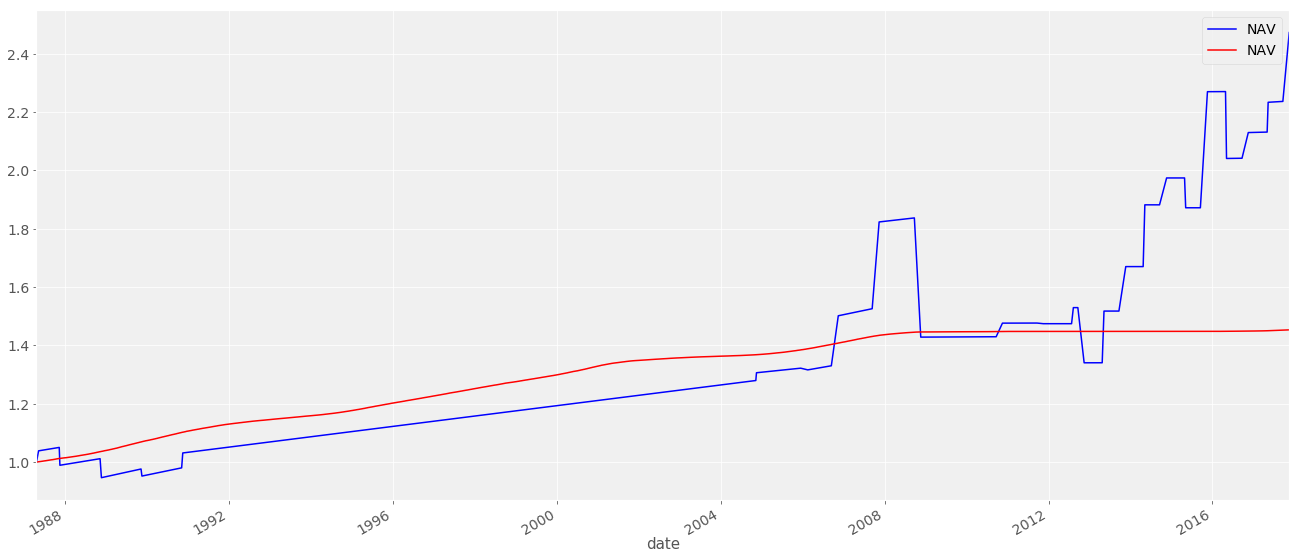

In [282]:
ax2 = Portfolio2.plot(kind='line', x='date', y='NAV', color='Blue', figsize=(20,10))
benchmark.plot(kind='line', x='date', y='NAV', color='Red', ax=ax2)

In [32]:
def Portfolio_Implement(df1, df21, df22, df3, fund, cost):
    # df1: historical prices
    # df21: strategy with all dividends increase announcements sorted by long date
    # df22: strategy with all dividends increase announcements sorted by short date
    # df3: risk free rates
    # fund: the initial value
    # cost: trading cost (per trade)
    LONG = df21['Long Date'].unique()
    LONG = pd.DataFrame({'date':LONG, 'action': 'long'}, columns=['date', 'action'])
    SHORT = df22['Short Date'].unique()
    SHORT = pd.DataFrame({'date':SHORT, 'action': 'short'}, columns=['date', 'action'])
    TF = pd.concat([LONG, SHORT])
    TF = TF.sort_values('date')
    TF = TF.reset_index(drop=True)
    df3 = df3[(df3['date'] >= df21['Long Date'].iloc[0]) & (df3['date'] <= df1['date'].iloc[-1])]
    N = TF.shape[0]
    date = []
    action = []
    NAV = []
    inventory = pd.DataFrame(columns = ['PERMNO', 'Price', 'Share'])
    proceed = 0
    short = None

    for i in tqdm(range(N)):
        if (TF['action'].iloc[i] == 'long'):
            long = TF['date'].iloc[i]
            date.append(long)
            action.append('long')
            
            if (i == 0):
                print('------First day------')
                NAV.append(fund*(1-cost))
                sub = df21[df21['Long Date'] == long]
                m = sub.shape[0] # number of new stocks 
                for k in range(m):
                    company = sub['PERMNO'].iloc[k]
                    price = sub['Long Price'].iloc[k]
                    share = (fund/m)/price
                    inventory.loc[k] = [company, price, share]
                
            elif (len(inventory)>0):
                print('-----Long Date-----',long)
                
                n = inventory.shape[0] # number of existing stocks
                company = np.array(inventory['PERMNO'])
                for k in range(n):
                    temp = long
                    check = df1[(df1['PERMNO'] == company[k]) & (df1['date'] == temp)]
                    while (len(check) == 0):
                        print('*********')
                        temp = temp - datetime.timedelta(days=7-temp.weekday() if temp.weekday()>3 else 1) # previous business day 
                        check = df1[(df1['PERMNO'] == company[k]) & (df1['date'] == temp)]
                    inventory['Price'].iloc[k] = check['Adjust Price'].iloc[0]
                
                stock_values = (inventory['Price']*inventory['Share']).sum()

                
                if (short is None):
                    print('-----no short so far-----')
                    nav = stock_values
                elif (short == long):
                    print('-----short = long-----')
                    nav = NAV[-1]
                elif (short < long):
                    print('-----break------')
                    print('proceed before earning RF',proceed)
                    rf = np.array(df3[(df3['date'] > short) & (df3['date'] <= long)]['RF'])
                    proceed = proceed*(np.cumprod(rf+1)[-1])
                    print('proceed after earning RF',proceed)
                    nav = stock_values + proceed
                    
                sub = df21[df21['Long Date'] == long]
                m = sub.shape[0] # number of new stocks
                trading_cost = cost*(2*nav*m/(n+m)) # trading cost 
                NAV.append(nav-trading_cost)
                value = NAV[-1]/(n+m) # new value assigned to each stock
                
                print('number of existing stocks', n)
                print('number of new stocks', m)
                print('new value assigned', value)
                
                for k in range(m):
                    company = sub['PERMNO'].iloc[k]
                    price = sub['Long Price'].iloc[k]
                    share = value/price
                    inventory.loc[n+k] = [company, price, share]
                inventory['Share'] = value/inventory['Price']
                print(inventory)

                
            elif (len(inventory)==0):
                print('-----no inventory-----')
                if (short == long):
                    NAV.append(NAV[-1]*(1-cost))
                elif (short < long):
                    rf = np.array(df3[(df3['date'] > short) & (df3['date'] <= long)]['RF'])
                    proceed = proceed*(np.cumprod(rf+1)[-1])
                    NAV.append(proceed*(1-cost))
                
                sub = df21[df21['Long Date'] == long]
                m = sub.shape[0] # number of new stocks
                print('number of new stocks', m)
                for k in range(m):
                    company = sub['PERMNO'].iloc[k]
                    price = sub['Long Price'].iloc[k]
                    share = (NAV[-1]/m)/price
                    inventory.loc[k] = [company, price, share]
            
            proceed = 0 # reset proceed since all are reinvested
            print(NAV[-1])
            
        else:
            short = TF['date'].iloc[i]
            date.append(short)
            action.append('short')
            print('-----Short Date-----',short)
            print('new inventory before short')
            print(inventory)
            
            if (long < short):
                rf = np.array(df3[(df3['date'] > long) & (df3['date'] <= short)]['RF'])
                proceed = proceed*(np.cumprod(rf+1)[-1])
            
            print('new proceed', proceed)
            
            sub = df22[df22['Short Date'] == short]
            l = sub.shape[0] # number of stocks to short
            
            for k in range(l):
                company = sub['PERMNO'].iloc[k]
                price = sub['Short Price'].iloc[k]
                dividend = sub['Dividend'].iloc[k]
                share = inventory[inventory['PERMNO'] == company]['Share'].sum()
                proceed = proceed + price*share*(1-cost) + dividend*share
                inventory = inventory[inventory['PERMNO'] != company] # remove the stock from inventory
                inventory = inventory.reset_index(drop=True)
                
            n = inventory.shape[0] # number of existing stocks
            company = np.array(inventory['PERMNO'])
            for k in range(n):
                temp = short
                check = df1[(df1['PERMNO'] == company[k]) & (df1['date'] == temp)]
                while (len(check) == 0):
                    print('*********')
                    temp = temp - datetime.timedelta(days=7-temp.weekday() if temp.weekday()>3 else 1) # previous business day 
                    check = df1[(df1['PERMNO'] == company[k]) & (df1['date'] == temp)]
                inventory['Price'].iloc[k] = check['Adjust Price'].iloc[0]
            
            print('new inventory after short')
            print(inventory)
            
            stock_values = (inventory['Price']*inventory['Share']).sum()
            NAV.append(proceed + stock_values)
            print(NAV[-1])
    
    df = {'date':date, 'action':action, 'NAV': NAV}
    print(len(date), len(action), len(NAV))
    df = pd.DataFrame(df, columns = ['date', 'action', 'NAV'])
    return df
    

In [ ]:
Portfolio2 = Portfolio_Implement(D1, D21, D22, risk_free, fund=1)